In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_excel('Folds5x2_pp.xlsx')

In [2]:
dataset.shape

(9568, 5)

In [3]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


<Axes: >

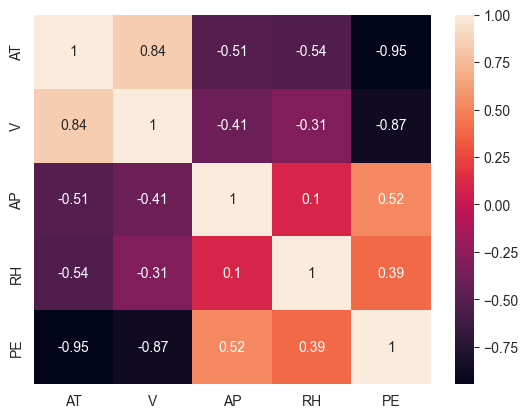

In [4]:
from seaborn import heatmap

heatmap(dataset.corr(),annot=True)

In [5]:
X = dataset.drop(columns=['PE']).values
y = dataset['PE'].values.reshape(-1,1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100, shuffle=True)

In [7]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [8]:
from keras_tuner import HyperParameters, GridSearch
from keras.models import Model
from keras.layers import Input,Dense
from keras.callbacks import EarlyStopping



In [9]:
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.backend import square,epsilon,sum,mean


def r_squared(y_true,y_pred):
    ss_res = sum(square(y_true - y_pred))
    ss_tot = sum(square(y_true - mean(y_true)))
    return 1 - ss_res / (ss_tot + epsilon())


In [10]:
def model_builder(hp: HyperParameters) -> Model:
    inputs = Input(shape=(4,), name='input', dtype=np.float32)
    units1 = hp.Int('units1', min_value=8, max_value=32, step=4)
    dense1 = Dense(units1,name='dense_1', activation='relu')(inputs)
    units2 = hp.Int('units2', min_value=4, max_value=16, step=2)
    dense2 = Dense(units2,name='dense_2', activation='relu')(dense1)
    output1 = Dense(1,name='output')(dense2)
    model = Model(inputs = inputs, outputs = output1, name="power_output_prediction_model")
    lr = hp.Float('learning_rate', min_value=1e-3,max_value=1e-2, step=1e-3)
    model.compile(loss=MeanSquaredError(name='loss'),
                  optimizer=Adam(learning_rate=lr),
                  metrics=[r_squared]
                  )
    return model

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.05,  # najmanja promena u odnosu na prethodnu epohu
                               patience=2,
                               # broj epoha sa promenom manjom od delta vrednosti nakon ceka trening staje
                               verbose=1,  # da prikaze zasto je trening zaustavljen
                               restore_best_weights=True)

In [12]:
tuner = GridSearch(model_builder,objective='val_loss', seed=100)

In [13]:
tuner.search(X_train,y_train,epochs = 50, validation_split = 0.2,callbacks=[early_stopping])

Trial 490 Complete [00h 00m 02s]
val_loss: 0.056894391775131226

Best val_loss So Far: 0.054505813866853714
Total elapsed time: 00h 13m 32s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [15]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, epochs=50, validation_split=0.2, shuffle = True,callbacks=[early_stopping])



Epoch 1/50
180/180 [==============================] - 1s 2ms/step - loss: 0.0930 - r_squared: 0.9041 - val_loss: 0.0667 - val_r_squared: 0.9299
Epoch 2/50
180/180 [==============================] - 0s 1ms/step - loss: 0.0633 - r_squared: 0.9323 - val_loss: 0.0607 - val_r_squared: 0.9364
Epoch 3/50
180/180 [==============================] - 0s 1ms/step - loss: 0.0606 - r_squared: 0.9353 - val_loss: 0.0562 - val_r_squared: 0.9411
Epoch 3: early stopping


In [16]:
history =  pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))

history.to_csv('history-tuned.csv', index=True, index_label = "Epoch")

In [41]:
eval = hypermodel.evaluate(X_test,y_test)

75/75 [==============================] - 0s 957us/step - loss: 0.0752 - r_squared: 0.9198


In [42]:
eval[0] = np.round(np.sqrt(eval[0]),3)
eval[1] = np.round(eval[1],3)

In [25]:
pd.DataFrame(data=np.array(eval).reshape(1,len(eval)), index=[0], columns=['RMSE','R SQUARED']).to_csv('results-tuned.csv',index=False)

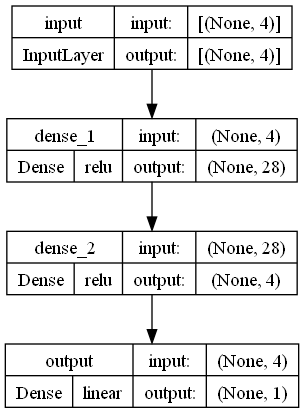

In [22]:
from keras.utils import plot_model

plot_model(hypermodel, to_file='model-tuned.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)